In [1]:
#import local radiospectra module

%matplotlib notebook
import os, sys
top_dir = os.path.split(os.path.realpath('.'))[0]
if top_dir != sys.path[0] and top_dir != sys.path[1]:
    sys.path.insert(1,top_dir)
path_to_import = os.path.abspath(top_dir + "\\radiospectra")

import radiospectra
if(path_to_import != os.path.abspath(radiospectra.__path__[0])):
    print(f'Module to import: {path_to_import}')
    print(f'Module that was imported: {os.path.abspath(radiospectra.__path__[0])}')
    raise Exception('Wrong radiospectra module was imported. (not local)')
else:
    print(f'Imported local radiospectra from: {os.path.abspath(radiospectra.__path__[0])}')
from radiospectra.sources import CallistoSpectrogram

Imported local radiospectra from: D:\WORK\ECALLISTO\radiospectra\radiospectra


In [ ]:
# read CallistoSpectrogram from fits file

spec = CallistoSpectrogram.read("example_callisto_border/ALASKA_20180401_000000_59.fit.gz")
spec.peek()
%xdel spec

In [ ]:
# read CallistoSpectrogram from fits file and extend it

spec = CallistoSpectrogram.read("example_callisto_border/ALASKA_20180401_000000_59.fit.gz")
spec = spec.extend().extend(-1)
spec.peek()
%xdel spec

In [ ]:
# load CallistoSpectrogram from the internet via url

spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2018/04/01/ALASKA_20180401_150000_59.fit.gz')
spec.peek()
%xdel spec

In [ ]:
# load CallistoSpectrogram's in a time range from the internet and combine them

spec = CallistoSpectrogram.from_range('ALASKA', '2018-04-01T00:00:00', '2018-04-02T00:00:00')
spec.peek()
print(spec.shape)
%xdel spec

In [ ]:
# Load and join a series of spectrograms of the same instrument

import os
spectrograms = []

for root, dirs, files in os.walk("example_callisto_joining", topdown = False):
    for file in files:
        full_name = os.path.join(root, file)
        spec = CallistoSpectrogram.read(full_name)
        spectrograms.append(spec)
        
spec_joined = CallistoSpectrogram.new_join_many(spectrograms)
spec_joined.peek()

In [ ]:
# current implementation of the background subtraction

spec_joined_default_bgs = spec_joined.subtract_bg()
spec_joined_default_bgs.peek(vmin=0)

In [ ]:
# new implementation of the background subtraction with a sliding window
# Arguments:
#   window_width   - the width of the sliding window that is used to determine the background for the current position
#   affected_width - the width of the "window" for that the current determined background is used
#                    also determines how much the sliding window is moved each itteration
#   amount         - The percent amount (out of 1) of lowest standard deviation to consider.
#                    (this is the same as in the current implementation BUT applied to the sliding window)

# NOTE:
# currently returns three CallistoSpectrogram objects to make it easier to view the results
# 1. The original spectrogram with the background subtracted
# 2. The detected background
# 3. A plot to show which columns were used how many times in the process of detecing the background
# This is used to debug and analyze.
# This is not to stay like this since number three is no Spectrogram
# and the headers of number one and two are not adjusted to the background subtraction
# The final version should only return number one with correct headers
# Number two and three should still be made available since they carry potentially important information


sliding_bgs, sliding_bg_only, sliding_column_freq = spec_joined.subtract_bg_sliding_window(
    window_width=5000, affected_width=10, amount=0.05)
sliding_bgs.peek(vmin=0)

In [ ]:
# Save the generated CallistoSpectrogram

from time import gmtime, strftime
file_name_save = str(f'example_callisto_joined/joined_{strftime("%Y_%m_%d_%H_%M_%S", gmtime())}.fit.gz')
sliding_bgs.save(file_name_save)

In [ ]:
# Load and display the saved CallistoSpectrogram

spec = CallistoSpectrogram.read(file_name_save)
spec.peek(vmin=0)


ALASKA-COHOE_20171029_001459_00.fit.gz	Callisto intensity 45 MHz-93MHz		COHOE, Alaska USA, LWA RHCP 300 KHz


<IPython.core.display.Javascript object>


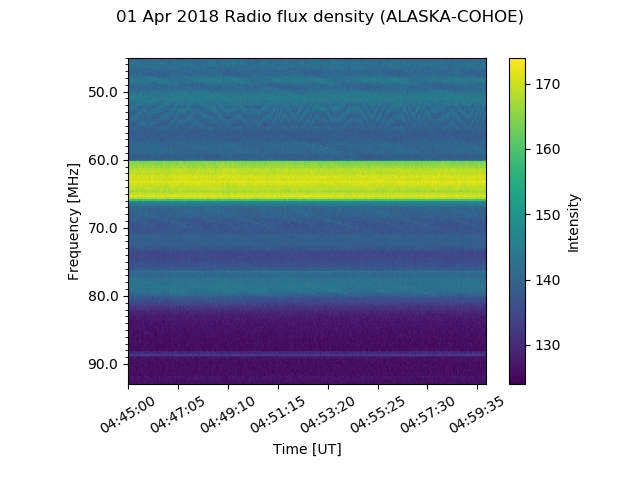

ALASKA-COHOE_20171029_001459_01.fit.gz	Callisto intensity 45 MHz-93MHz		COHOE, Alaska USA, LWA LHCP 300 KHZ


<IPython.core.display.Javascript object>


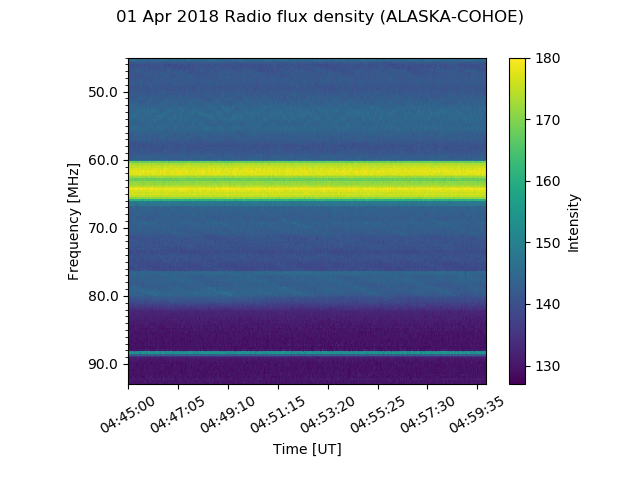

ALASKA-COHOE_20171029_001944_02.fit.gz	Callisto intensity 45 MHz-93MHz		COHOE, Alaska USA, LWA RHCP 80 KHz


<IPython.core.display.Javascript object>


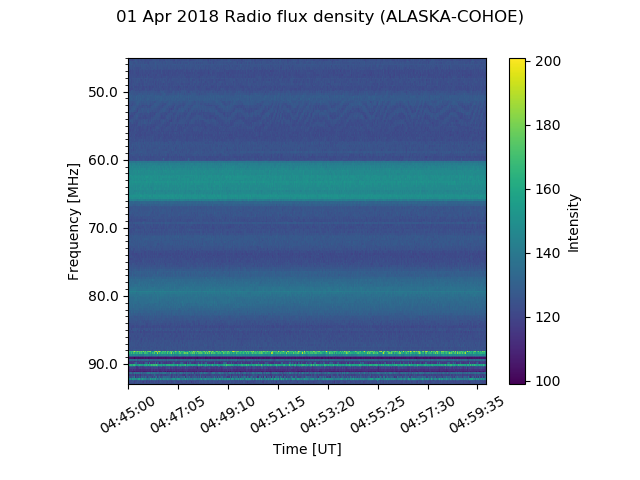

ALASKA-COHOE_20180401_044500_00.fit.gz
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3591 / length of data axis 1                          
NAXIS2  =                  200 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
DATE    = '2018-04-01'         / Time of observation                            
CONTENT = '2018/04/01  Radio flux density, e-CALLISTO (ALASKA-COHOE)' 

In [8]:
%matplotlib notebook
from radiospectra.sources import CallistoSpectrogram
print()
spec0 = CallistoSpectrogram.read(r'D:/WORK/ECALLISTO/ssa-ecallisto/background_subtraction/test_files/test_polar/ALASKA-COHOE_20180401_044500_00.fit.gz')
spec1 = CallistoSpectrogram.read(r'D:/WORK/ECALLISTO/ssa-ecallisto/background_subtraction/test_files/test_polar/ALASKA-COHOE_20180401_044500_01.fit.gz')
spec2 = CallistoSpectrogram.read(r'D:/WORK/ECALLISTO/ssa-ecallisto/background_subtraction/test_files/test_polar/ALASKA-COHOE_20180401_044500_02.fit.gz')

print('ALASKA-COHOE_20171029_001459_00.fit.gz	Callisto intensity 45 MHz-93MHz		COHOE, Alaska USA, LWA RHCP 300 KHz')
spec0.peek()
print('ALASKA-COHOE_20171029_001459_01.fit.gz	Callisto intensity 45 MHz-93MHz		COHOE, Alaska USA, LWA LHCP 300 KHZ')
spec1.peek()
print('ALASKA-COHOE_20171029_001944_02.fit.gz	Callisto intensity 45 MHz-93MHz		COHOE, Alaska USA, LWA RHCP 80 KHz')
spec2.peek()

print(spec0.filename)
print(repr(spec0.header))
print()
print(spec1.filename)
print(repr(spec1.header))
print()
print(spec2.filename)
print(repr(spec2.header))